# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *

#from new_fit_development import *

paths_to_create_delete = [path_figures]


### Utility functions ###

def Dz_from_Da(a):
    z = a * sin(deg2rad(angle_incidence)) / sin(deg2rad(data.opt[2]))
    return z * channel_distance

def Dz_from_Ds(s):
    z = - s * sin(deg2rad(angle_incidence)) / cos(deg2rad(data.opt[2]))
    return z * channel_distance

# Read phase database

In [2]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5

Shape of data
-------------
x: 170, y: 95, channels: 1280

Initial calibration
-------------------
a = -1214.7, s = 1952.7, beta = 51.663
Theta range: [19.77907407899562, 53.578190550653794]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [4]:
qtl = 0.9997

data.correct_quantile_pixels(qtl)

5 pixels out of 16150 were corrected.


# Select primary phases

### Manually select them

In [5]:
hydrocerussite = database['Hydrocerussite'][0].select_peaks([]) #[i for i in range(15) if i != 3]
cinnabar = database['Cinnabar'][2].select_peaks([])
gold = database['Gold'][10].select_peaks([])
lead_tin_y = database['Lead-tin yellow'][0].select_peaks([])
lazurite = database['Lazurite'][0].select_peaks([])

#phases_primary = [hydrocerussite, gold, cinnabar, lead_tin_y] # Angelo
phases_primary = [hydrocerussite, cinnabar, lazurite] # Profilo

### Set parameters of synthetic XRD patterns
You can skip this cell and keep the preset values of the parameters.

In [6]:
min_theta = 20
max_theta = 53
min_intensity = 0.1    # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2            # sigma used in the peaks of synthetic diffraction patterns
distance_merge = sigma # Distance under which peaks are merged in each phase. Put None to avoid merging.

# Select point

In [56]:
#x, y = 97, 57 # Lazurite and hydrocerussite
x, y = 98, 57 # Lazurite and hydrocerussite
spectrum = FastSpectraXRD().from_Data(data, x, y)

### Process experimental XRD pattern

In [57]:
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

spectrum = spectrum.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

# Plot

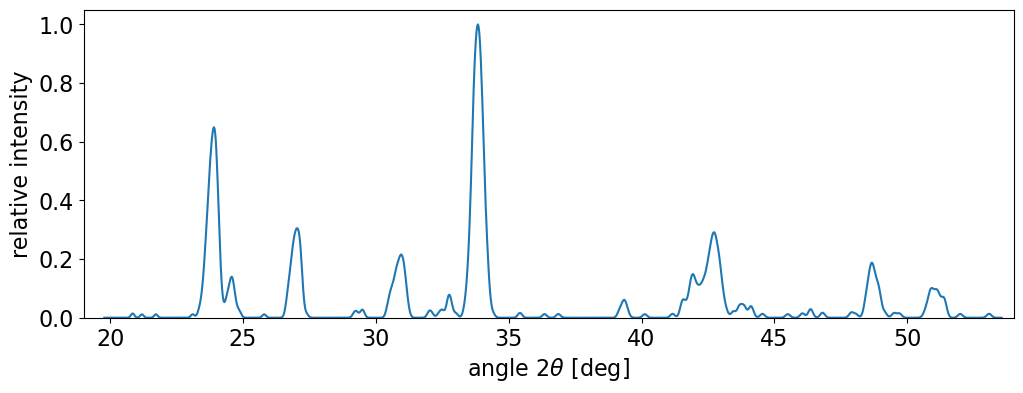

In [58]:
rcParams['font.size'] = 16

fig, ax = subplots(figsize = (12, 4))
ax.plot(spectrum.theta, spectrum.intensity)
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$ [deg]')
ax.set_ylabel(r'relative intensity')
show()

# Fit 2 phases

In [59]:
gn2 = GaussNewton_2Phases([lazurite, hydrocerussite], spectrum, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

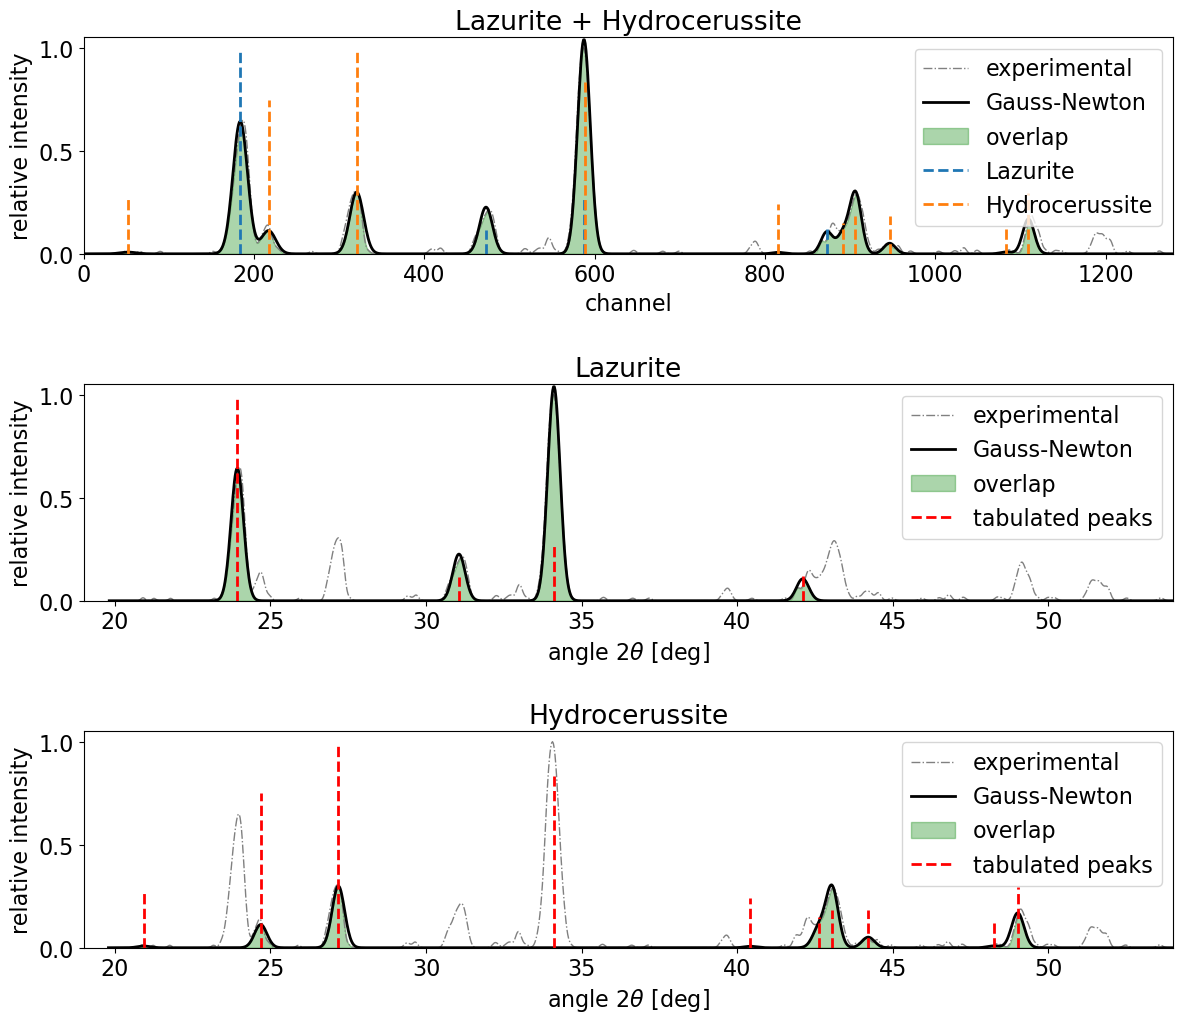

a1 = -1197.43, a2 = -1198.60, s = 1928.43, beta = 51.66
gamma1: [0.64353986 1.94090378 3.8517632  0.81806906]
gamma2: [0.02994725 0.15023323 0.29970637 0.         0.02796323 0.62994549
 1.62276072 0.28167707 0.06977131 0.57825687]
overlap = 0.40988054217674075


In [63]:
rcParams['font.size'] = 16

fig, axs = subplots(3, 1, figsize = (12, 10))
fig.tight_layout(h_pad = 4, w_pad = 4)

ax = axs[0]
sca(ax)
ax.plot(gn2.channel, gn2.intensity, c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn2.channel, gn2.z(), c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
ax.fill_between(gn2.channel, gn2.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
for idx, color_label in enumerate(['tab:blue', 'tab:orange']):
    gn2.plot_phase(
        idx,
        x_axis_is_channel = True,
        calibration_function_theta_to_channel = gn2.fce_calibration_inverse,
        calibration_parameters = (gn2.opt[idx], gn2.opt[2], gn2.opt[3]),
        color = color_label, lw = 2, alpha = 1, label = gn2.phases[idx].label
    )

ax.legend(frameon = True, loc = 'upper right')

ax.set_xlim(*gn2.channel[[0, -1]])
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'channel')
ax.set_ylabel(r'relative intensity')
ax.set_title(gn2.label)

for idx in [0, 1]:
    ax = axs[idx + 1]
    sca(ax)
    ax.plot(gn2.theta[idx], gn2.intensity, c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn2.theta[idx], gn2.z_partial(idx), c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    ax.fill_between(gn2.theta[idx], gn2.overlap_partial(idx), color = 'g', alpha = 0.33, label = 'overlap')
    gn2.plot_phase(idx, lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.legend(frameon = True, loc = 'upper right')
    
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$ [deg]')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(gn2.phases[idx].label)
show()
print(f'a1 = {gn2.opt[0]:.2f}, a2 = {gn2.opt[1]:.2f}, s = {gn2.opt[2]:.2f}, beta = {gn2.opt[3]:.2f}')
print(f'gamma1: {gn2.gamma[0]}\ngamma2: {gn2.gamma[1]}')
print(f'overlap =', gn2.phase_presence(method = 'adjustment_ratio', correction = False))

In [61]:
for i in range(8):
    gn2.fit(gamma = True)
for i in range(8):
    gn2.fit(a = False, s = True, gamma = True)

In [62]:
for i in range(8):
    gn2.fit(a = True, s = True, gamma = True)

In [64]:
calibration_a_diff = gn2.opt[1] - gn2.opt[0]
print(f'Delta a = {calibration_a_diff :.3f} channels = {channel_distance * calibration_a_diff :.3f} micron')
print(f'Delta z = {Dz_from_Da(calibration_a_diff) :.3f} micron')

Delta a = -1.174 channels = -58.699 micron
Delta z = -13.638 micron
